# Import

In [1]:
%pip install mlxtend


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import numpy as np
import matplotlib.pyplot as plt

# Load

In [3]:
path = './scanner_data.csv'
df = pd.read_csv(path)

In [4]:
df

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,2,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,3,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,4,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,5,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88
...,...,...,...,...,...,...,...,...
131701,131702,04/07/2016,20203,32900,IEV,FO112,3.0,6.46
131702,131703,04/07/2016,20203,32900,N8U,I36F2,1.0,4.50
131703,131704,04/07/2016,20203,32900,U5F,4X8P4,1.0,5.19
131704,131705,04/07/2016,20203,32900,0H2,ZVTO4,1.0,4.57


In [5]:
df.describe()

,Unnamed: 0,Customer_ID,Transaction_ID,Quantity,Sales_Amount
count,131706.000000,131706.000000,131706.000000,131706.000000,131706.000000
mean,65853.500000,12386.450367,32389.604187,1.485311,11.981524
std,38020.391614,6086.447552,18709.901238,3.872667,19.359699
min,1.000000,1.000000,1.000000,0.010000,0.020000
25%,32927.250000,7349.000000,16134.000000,1.000000,4.230000
50%,65853.500000,13496.000000,32620.000000,1.000000,6.920000
75%,98779.750000,17306.000000,48548.000000,1.000000,12.330000
max,131706.000000,22625.000000,64682.000000,400.000000,707.730000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      131706 non-null  int64  
 1   Date            131706 non-null  object 
 2   Customer_ID     131706 non-null  int64  
 3   Transaction_ID  131706 non-null  int64  
 4   SKU_Category    131706 non-null  object 
 5   SKU             131706 non-null  object 
 6   Quantity        131706 non-null  float64
 7   Sales_Amount    131706 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 8.0+ MB


In [7]:
print(f"Broj ulaza u skupu podataka: {len(df)}")

Broj ulaza u skupu podataka: 131706


In [8]:
print(f"Broj ulaznih promenljivih u skupu podataka: {len(df.iloc[0])}")

Broj ulaznih promenljivih u skupu podataka: 8


Atributi u skupu podataka:
- $Unnamed:0$ - ID svakog reda i suvišan je atribut, zato ga izbacujemo
- $Date$ - datum kada je izvršena prodaja
- $Customer\_ID$ - ID kupca
- $Transaction\_ID$ - ID transakcije, odnosno kupovine
- $SKU\_Category$ - kategorija prodatog artikla
- $SKU$ - ID prodatog artikla
- $Quantity$ - količina prodatog artikla
- $Sales\_amount$ - zarada od prodaje (cena * kolicina)

In [9]:
df.describe(include=['O'])

,Date,SKU_Category,SKU
count,131706,131706,131706
unique,363,187,5242
top,23/09/2016,N8U,UNJKW
freq,638,10913,2007


- Postoje 187 jedinstvenih kategorija artikla i 5242 jedinstvenih ID-eva artikla

- Cilj nam je da odredimo artikle koje ljudi cesto kupuju zajedno

# Analiza podataka

- Prvo izbacimo $Unnamed:0$

In [10]:
df.drop(['Unnamed: 0'],inplace=True, axis=1)

In [11]:
transaction_item_count = df.groupby(['Transaction_ID'])['SKU'].count().sort_values(ascending=True)
item_count_dict = {int(i) : 0  for i in transaction_item_count.unique()}
for i in transaction_item_count:
    item_count_dict[i] += 1
item_count_dict

{1: 32906,
 2: 16845,
 3: 6802,
 4: 3478,
 5: 1851,
 6: 1036,
 7: 646,
 8: 426,
 9: 254,
 10: 167,
 11: 94,
 12: 64,
 13: 52,
 14: 23,
 15: 16,
 16: 4,
 17: 6,
 18: 4,
 19: 5,
 20: 1,
 21: 2}

(array([3.2906e+04, 1.6845e+04, 6.8020e+03, 3.4780e+03, 1.8510e+03,
        1.0360e+03, 6.4600e+02, 4.2600e+02, 2.5400e+02, 1.6700e+02,
        9.4000e+01, 6.4000e+01, 5.2000e+01, 2.3000e+01, 1.6000e+01,
        4.0000e+00, 6.0000e+00, 4.0000e+00, 5.0000e+00, 3.0000e+00]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21.]),
 <BarContainer object of 20 artists>)

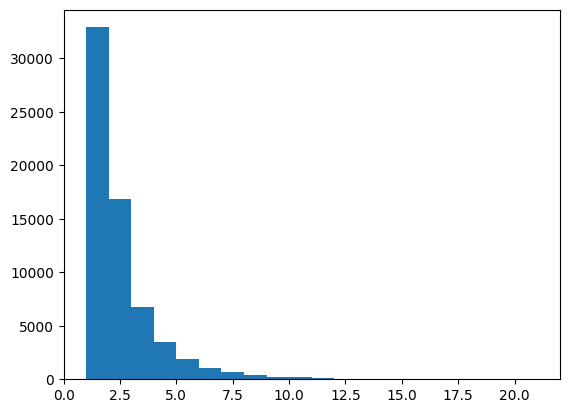

In [12]:
plt.hist(transaction_item_count, bins =20)

Vidimo da većina transakcija se sastoji samo od 1 artikla

**Enkodirajmo proizvode korišćenjem one hot encode-inga kako bi dobili bool vrednosti da li se proizvod nalazi u transakciji ili ne**
- To činimo jer apriori algoritam radi sa bool vrednostima
- Želimo da za svaku transakciju vidimo koji proizvodi se javljaju

In [13]:
quantity_by_transaction_product = df.groupby(['Transaction_ID', 'SKU'])['Quantity'].any().unstack().fillna(False)
quantity_by_transaction_product

/var/folders/vk/66zsqmfd3vbc1yycqb9f7r340000gn/T/ipykernel_35370/195629592.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  quantity_by_transaction_product = df.groupby(['Transaction_ID', 'SKU'])['Quantity'].any().unstack().fillna(False)


SKU,00GVC,00OK1,0121I,01IEO,01IQT,01L05,01V7M,01XVY,029WA,03C6L,...,ZWNCK,ZWWB5,ZX2UM,ZY9N9,ZYF2U,ZZ2AO,ZZDW7,ZZM1A,ZZNC5,ZZX6K
Transaction_ID,,,,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64678,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
64679,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
64680,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
apriori_result_transactions = apriori(quantity_by_transaction_product, min_support=0.001,use_colnames=True, low_memory=True)
apriori_result_transactions

,support,itemsets
0,0.001809,(09LL9)
1,0.001098,(0AEJH)
2,0.001160,(0D3EZ)
3,0.001994,(0DCAY)
4,0.001144,(0HUPP)
...,...,...
465,0.003911,(ZUN8X)
466,0.003370,(ZVTO4)
467,0.001283,(ZWFSY)
468,0.001036,"(3YDVF, DWJC4)"


In [15]:
rules_transactions =  association_rules(apriori_result_transactions, metric="lift", min_threshold=1)
rules_transactions

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(3YDVF),(DWJC4),0.008178,0.009075,0.001036,0.126654,13.956113,0.000962,1.134630,0.936002
1,(DWJC4),(3YDVF),0.009075,0.008178,0.001036,0.114140,13.956113,0.000962,1.119614,0.936849
2,(COWU2),(UNJKW),0.012229,0.031029,0.001098,0.089760,2.892797,0.000718,1.064523,0.662414
3,(UNJKW),(COWU2),0.031029,0.012229,0.001098,0.035376,2.892797,0.000718,1.023996,0.675266


In [16]:
sorted = rules_transactions.sort_values(by = 'lift', ascending=False)
top_results = 10

for i in range(min(top_results,len(sorted))):
    X = list(sorted['antecedents'].iloc[i])
    Y = list(sorted['consequents'].iloc[i])
    lift = sorted['lift'].iloc[i]
    print(f"Transakcije koje su sadržale proizvode {X} su vrlo često sadržale i proizvod {Y}, lift: {lift}")

Transakcije koje su sadržale proizvode ['DWJC4'] su vrlo često sadržale i proizvod ['3YDVF'], lift: 13.956112751712435
Transakcije koje su sadržale proizvode ['3YDVF'] su vrlo često sadržale i proizvod ['DWJC4'], lift: 13.956112751712434
Transakcije koje su sadržale proizvode ['UNJKW'] su vrlo često sadržale i proizvod ['COWU2'], lift: 2.8927968293022466
Transakcije koje su sadržale proizvode ['COWU2'] su vrlo često sadržale i proizvod ['UNJKW'], lift: 2.892796829302246


### Uradimo isto, ali grupišimo po drugim atributima
- Možemo da ispitamo tendencije kupovine kupaca

In [17]:
quantity_by_customer_product = df.groupby(['Customer_ID', 'SKU'])['Quantity'].any().unstack().fillna(False)
quantity_by_customer_product

/var/folders/vk/66zsqmfd3vbc1yycqb9f7r340000gn/T/ipykernel_35370/3394133573.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  quantity_by_customer_product = df.groupby(['Customer_ID', 'SKU'])['Quantity'].any().unstack().fillna(False)


SKU,00GVC,00OK1,0121I,01IEO,01IQT,01L05,01V7M,01XVY,029WA,03C6L,...,ZWNCK,ZWWB5,ZX2UM,ZY9N9,ZYF2U,ZZ2AO,ZZDW7,ZZM1A,ZZNC5,ZZX6K
Customer_ID,,,,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22621,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
22622,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
22623,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [18]:
apriori_result_customers = apriori(quantity_by_customer_product, min_support=0.001,use_colnames=True)
apriori_result_customers

,support,itemsets
0,0.001017,(0121I)
1,0.001503,(01IEO)
2,0.001591,(01V7M)
3,0.001370,(03C6L)
4,0.001017,(062O9)
...,...,...
1430,0.001635,"(UNJKW, ZSVWE)"
1431,0.001326,"(ZUN8X, UNJKW)"
1432,0.001326,"(ZVTO4, UNJKW)"
1433,0.001238,"(W14J3, W1ZMG)"


In [19]:
rules_customers = association_rules(apriori_result_customers, metric="lift", min_threshold=1)
rules_customers

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(0LCSZ),(DWJC4),0.004376,0.014674,0.001017,0.232323,15.832268,0.000952,1.283517,0.940955
1,(DWJC4),(0LCSZ),0.014674,0.004376,0.001017,0.069277,15.832268,0.000952,1.069732,0.950790
2,(0OZBT),(QGK3S),0.005834,0.018077,0.001017,0.174242,9.638716,0.000911,1.189117,0.901511
3,(QGK3S),(0OZBT),0.018077,0.005834,0.001017,0.056235,9.638716,0.000911,1.053404,0.912752
4,(0T6EB),(0S4F6),0.002077,0.002166,0.001149,0.553191,255.427703,0.001145,2.233248,0.998159
...,...,...,...,...,...,...,...,...,...,...
597,"(COWU2, M6J9W)",(UNJKW),0.003624,0.072840,0.001149,0.317073,4.353022,0.000885,1.357627,0.773076
598,"(UNJKW, M6J9W)",(COWU2),0.004773,0.030099,0.001149,0.240741,7.998178,0.001005,1.277430,0.879168
599,(COWU2),"(UNJKW, M6J9W)",0.030099,0.004773,0.001149,0.038179,7.998178,0.001005,1.034732,0.902125
600,(UNJKW),"(COWU2, M6J9W)",0.072840,0.003624,0.001149,0.015777,4.353022,0.000885,1.012347,0.830789


In [20]:
sorted = rules_customers.sort_values(by = 'lift', ascending=False)
top_results = 10

for i in range(top_results):
    X = list(sorted['antecedents'].iloc[i])
    Y = list(sorted['consequents'].iloc[i])
    lift = sorted['lift'].iloc[i]
    print(f"Kupci koji su kupili proizvod {X} su vrlo često kupovali i proizvod {Y}, lift: {lift}")

Kupci koji su kupili proizvod ['DJ7YG'] su vrlo često kupovali i proizvod ['NABDK'], lift: 673.6972704714641
Kupci koji su kupili proizvod ['NABDK'] su vrlo često kupovali i proizvod ['DJ7YG'], lift: 673.6972704714641
Kupci koji su kupili proizvod ['0T6EB'] su vrlo često kupovali i proizvod ['0S4F6'], lift: 255.42770299609208
Kupci koji su kupili proizvod ['0S4F6'] su vrlo često kupovali i proizvod ['0T6EB'], lift: 255.42770299609202
Kupci koji su kupili proizvod ['5O2CO'] su vrlo često kupovali i proizvod ['3QNEE'], lift: 214.60027100271003
Kupci koji su kupili proizvod ['3QNEE'] su vrlo često kupovali i proizvod ['5O2CO'], lift: 214.60027100271003
Kupci koji su kupili proizvod ['CG1YR'] su vrlo često kupovali i proizvod ['ZGSKV'], lift: 211.05410447761193
Kupci koji su kupili proizvod ['ZGSKV'] su vrlo često kupovali i proizvod ['CG1YR'], lift: 211.05410447761193
Kupci koji su kupili proizvod ['3483Q'] su vrlo često kupovali i proizvod ['6V2Q8'], lift: 58.955984818444456
Kupci koji s